<a href="https://colab.research.google.com/github/diqksrk/hanghaeAI2/blob/main/2weekhomework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [전체 코드]

In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from torch import nn
from math import sqrt
import numpy as np
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from transformers.models.paligemma.convert_paligemma_weights_to_hf import device

ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

class MultiHeadAttention(nn.Module):
  # Multi-head attention으로 변경하므로, reshape를 위해 n_heads 파라미터를 추가한다
  def __init__(self, input_dim, d_model, n_heads=4):
    super().__init__()

    assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

    self.input_dim = input_dim
    self.d_model = d_model
    self.n_heads = n_heads
    self.d_head = d_model // n_heads

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    batch_size = x.size(0)
    seq_len = x.size(1)

    # (B,S,D) -> (B, S, n_heads, d_head)를 transpose를 통해 -> (B,n_heads,S,d_head)로 shape을 변경합니다.
    q = self.wq(x).view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)
    k = self.wk(x).view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)
    v = self.wv(x).view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)

    # 내적을 수행하면서 (B,n_heads,S,d_head) -> (B, n_heads, S, S)로 변경합니다.
    score = torch.matmul(q, k.transpose(-1, -2))
    score = score / sqrt(self.d_head)

    if mask is not None:
      # (B, S, S)의 mask shape을 score shape에 맞는 (B, n_heads, S, S)로 변경 후 mask 처리를 수행합니다.
      mask = mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1)
      score = score.masked_fill(mask == 0, -1e9)

    score = self.softmax(score)
    # value값을 내적하면서 (B, n_heads, S, S) -> (B,n_heads,S,d_head)로 변경합니다.
    result = torch.matmul(score, v)

    # (B,n_heads,S,d_head)를 다시 초기형태인 (B,S,D)로 변경해줍니다.
    result = result.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
    result = self.dense(result)

    return result

class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.mha = MultiHeadAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )
    self.dropout = nn.Dropout(0.1)

  def forward(self, x, mask):
    x1 = self.mha(x, mask)
    # dropout을 통해, 뉴런들의 의존도를 최소화합니다.
    x1 = self.dropout(x1)
    # residual connection을 수행한후, 값이 너무 커지거나 작아질 경우를 방지하기 위해 LayerNorm 정규화를 수행합니다.
    x1 = nn.LayerNorm(x1.size()[1:]).to(x1.device)(x1 + x)

    x2 = self.ffn(x1)
    x1 = self.dropout(x2)
    x2 = nn.LayerNorm(x2.size()[1:]).to(x2.device)(x2 + x1)

    return x2

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  pos_encoding = angle_rads[None, ...]

  return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 1)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x

model = TextClassifier(len(tokenizer), 32, 5, 32)

device = torch.device("mps")
lr = 0.001
model = model.to(device)
loss_fn = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=lr)

def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

n_epochs = 50
train_acc_list = []
test_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device).float()

    preds = model(inputs)[..., 0]
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

# Plotting function
def plot_acc(train_acc_list, test_acc_list, label1='train_acc', label2='test_acc'):
    x = np.arange(len(train_acc_list))

    plt.plot(x, train_acc_list, label=label1)
    plt.plot(x, test_acc_list, label=label2)
    plt.legend()
    plt.show()

plot_acc(train_acc_list, test_acc_list)

## [MyCode]
Multi-head attention으로 변경하므로, reshape를 위해 n_heads 파라미터를 추가합니다.

In [ ]:
class MultiHeadAttention(nn.Module):
  # Multi-head attention으로 변경하므로, reshape를 위해 n_heads 파라미터를 추가한다
  def __init__(self, input_dim, d_model, n_heads=4):
    super().__init__()

    assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

    self.input_dim = input_dim
    self.d_model = d_model
    self.n_heads = n_heads
    self.d_head = d_model // n_heads

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

## [MyCode]
1. q, k ,v를 (B,S,D) -> (B, S, n_heads, d_head)를 transpose를 통해 -> (B,n_heads,S,d_head)로 shape을 변경합니다.
2. 내적을 수행하면서 (B,n_heads,S,d_head) -> (B, n_heads, S, S)로 변경합니다.
3. (B, S, S)의 mask shape을 score shape에 맞는 (B, n_heads, S, S)로 변경 후 mask 처리를 수행합니다.
4. value값을 내적하면서 (B, n_heads, S, S) -> (B,n_heads,S,d_head)로 변경합니다.
5. (B,n_heads,S,d_head)를 다시 초기형태인 (B,S,D)로 변경해줍니다.

In [ ]:
class MultiHeadAttention(nn.Module):
  # Multi-head attention으로 변경하므로, reshape를 위해 n_heads 파라미터를 추가한다
  def __init__(self, input_dim, d_model, n_heads=4):
    super().__init__()

    assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

    self.input_dim = input_dim
    self.d_model = d_model
    self.n_heads = n_heads
    self.d_head = d_model // n_heads

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    batch_size = x.size(0)
    seq_len = x.size(1)

    # (B,S,D) -> (B, S, n_heads, d_head)를 transpose를 통해 -> (B,n_heads,S,d_head)로 shape을 변경합니다.
    q = self.wq(x).view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)
    k = self.wk(x).view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)
    v = self.wv(x).view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)

    # 내적을 수행하면서 (B,n_heads,S,d_head) -> (B, n_heads, S, S)로 변경합니다.
    score = torch.matmul(q, k.transpose(-1, -2))
    score = score / sqrt(self.d_head)

    if mask is not None:
      # (B, S, S)의 mask shape을 score shape에 맞는 (B, n_heads, S, S)로 변경 후 mask 처리를 수행합니다.
      mask = mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1)
      score = score.masked_fill(mask == 0, -1e9)

    score = self.softmax(score)
    # value값을 내적하면서 (B, n_heads, S, S) -> (B,n_heads,S,d_head)로 변경합니다.
    result = torch.matmul(score, v)

    # (B,n_heads,S,d_head)를 다시 초기형태인 (B,S,D)로 변경해줍니다.
    result = result.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
    result = self.dense(result)

    return result

## [MyCode]
Layer normalization, dropout, residual connection를 구현합니다.
1. dropout을 통해, 뉴런들의 의존도를 최소화합니다.
2. residual connection을 수행한후, 값이 너무 커지거나 작아질 경우를 방지하기 위해 LayerNorm 정규화를 수행합니다.

In [ ]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.mha = MultiHeadAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )
    self.dropout = nn.Dropout(0.1)

  def forward(self, x, mask):
    x1 = self.mha(x, mask)
    # dropout을 통해, 뉴런들의 의존도를 최소화합니다.
    x1 = self.dropout(x1)
    # residual connection을 수행한후, 값이 너무 커지거나 작아질 경우를 방지하기 위해 LayerNorm 정규화를 수행합니다.
    x1 = nn.LayerNorm(x1.size()[1:]).to(x1.device)(x1 + x)

    x2 = self.ffn(x1)
    x1 = self.dropout(x2)
    x2 = nn.LayerNorm(x2.size()[1:]).to(x2.device)(x2 + x1)

    return x2

## [MyCode]
5-layer 4-head Transformer 로 파라미터를 변경합니다. 그리고 실행을 시켜 학습을 시키고 accuracy를 측정합니다.

In [ ]:
class MultiHeadAttention(nn.Module):
  # Multi-head attention으로 변경하므로, reshape를 위해 n_heads 파라미터를 추가한다
  def __init__(self, input_dim, d_model, n_heads=4):
    super().__init__()

...

# 5 = n_layers
model = TextClassifier(len(tokenizer), 32, 5, 32, num_classes)

## [LOG] 학습 과정에서의 Epoch별 손실값 출력
Epoch   0 | Train Loss: 270.62581408023834<br/>
=========> Train acc: 0.602 | Test acc: 0.590<br/>
Epoch   1 | Train Loss: 183.20040154457092<br/>
=========> Train acc: 0.838 | Test acc: 0.804<br/>
Epoch   2 | Train Loss: 128.89014473557472<br/>
=========> Train acc: 0.875 | Test acc: 0.836<br/>
Epoch   3 | Train Loss: 106.95590548962355<br/>
=========> Train acc: 0.910 | Test acc: 0.854<br/>
Epoch   4 | Train Loss: 90.95271319895983<br/>
=========> Train acc: 0.924 | Test acc: 0.849<br/>
Epoch   5 | Train Loss: 79.957384519279<br/>
=========> Train acc: 0.930 | Test acc: 0.846<br/>
Epoch   6 | Train Loss: 69.84446471557021<br/>
=========> Train acc: 0.940 | Test acc: 0.853<br/>
Epoch   7 | Train Loss: 62.58970504254103<br/>
=========> Train acc: 0.957 | Test acc: 0.858<br/>
Epoch   8 | Train Loss: 52.996340937912464<br/>
=========> Train acc: 0.970 | Test acc: 0.854<br/>
Epoch   9 | Train Loss: 48.063285337761045<br/>
=========> Train acc: 0.976 | Test acc: 0.853<br/>
Epoch  10 | Train Loss: 40.92732219956815<br/>
=========> Train acc: 0.980 | Test acc: 0.848<br/>
Epoch  11 | Train Loss: 38.07851804886013<br/>
=========> Train acc: 0.984 | Test acc: 0.843<br/>
Epoch  12 | Train Loss: 30.837283873930573<br/>
=========> Train acc: 0.978 | Test acc: 0.837<br/>
Epoch  13 | Train Loss: 27.54404871398583<br/>
=========> Train acc: 0.990 | Test acc: 0.844<br/>
Epoch  14 | Train Loss: 25.937904020305723<br/>
=========> Train acc: 0.982 | Test acc: 0.831<br/>
Epoch  15 | Train Loss: 21.737390383146703<br/>
=========> Train acc: 0.987 | Test acc: 0.841<br/>
Epoch  16 | Train Loss: 21.640705860685557<br/>
=========> Train acc: 0.989 | Test acc: 0.835<br/>
Epoch  17 | Train Loss: 20.242381155956537<br/>
=========> Train acc: 0.993 | Test acc: 0.837<br/>
Epoch  18 | Train Loss: 17.680186356883496<br/>
=========> Train acc: 0.994 | Test acc: 0.837<br/>
Epoch  19 | Train Loss: 17.68844081554562<br/>
=========> Train acc: 0.986 | Test acc: 0.836<br/>
Epoch  20 | Train Loss: 13.918300740653649<br/>
=========> Train acc: 0.995 | Test acc: 0.836<br/>
Epoch  21 | Train Loss: 16.192923292052<br/>
=========> Train acc: 0.995 | Test acc: 0.837<br/>
Epoch  22 | Train Loss: 14.165150376502424<br/>
=========> Train acc: 0.995 | Test acc: 0.835<br/>
Epoch  23 | Train Loss: 14.534585598157719<br/>
=========> Train acc: 0.995 | Test acc: 0.836<br/>
Epoch  24 | Train Loss: 16.342297722119838<br/>
=========> Train acc: 0.996 | Test acc: 0.834<br/>
Epoch  25 | Train Loss: 12.230833887355402<br/>
=========> Train acc: 0.987 | Test acc: 0.820<br/>
Epoch  26 | Train Loss: 12.903609764762223<br/>
=========> Train acc: 0.991 | Test acc: 0.824<br/>
Epoch  27 | Train Loss: 12.96005992195569<br/>
=========> Train acc: 0.992 | Test acc: 0.832<br/>
Epoch  28 | Train Loss: 12.347104709362611<br/>
=========> Train acc: 0.996 | Test acc: 0.833<br/>
Epoch  29 | Train Loss: 11.987704857019708<br/>
=========> Train acc: 0.996 | Test acc: 0.832<br/>
Epoch  30 | Train Loss: 12.40535369887948<br/>
=========> Train acc: 0.996 | Test acc: 0.835<br/>
Epoch  31 | Train Loss: 11.271425214130431<br/>
=========> Train acc: 0.996 | Test acc: 0.827<br/>
Epoch  32 | Train Loss: 11.587675305083394<br/>
=========> Train acc: 0.996 | Test acc: 0.833<br/>
Epoch  33 | Train Loss: 10.100348469801247<br/>
=========> Train acc: 0.996 | Test acc: 0.831<br/>
Epoch  34 | Train Loss: 10.2465748868417<br/>
=========> Train acc: 0.996 | Test acc: 0.833<br/>
Epoch  35 | Train Loss: 12.233022085623816<br/>
=========> Train acc: 0.996 | Test acc: 0.830<br/>
Epoch  36 | Train Loss: 13.503587702522054<br/>
=========> Train acc: 0.996 | Test acc: 0.829<br/>
Epoch  37 | Train Loss: 10.364826674340293<br/>
=========> Train acc: 0.997 | Test acc: 0.830<br/>
Epoch  38 | Train Loss: 8.70663694711402<br/>
=========> Train acc: 0.997 | Test acc: 0.828<br/>
Epoch  39 | Train Loss: 10.371194663224742<br/>
=========> Train acc: 0.995 | Test acc: 0.829<br/>
Epoch  40 | Train Loss: 10.228728022659197<br/>
=========> Train acc: 0.996 | Test acc: 0.829<br/>
Epoch  41 | Train Loss: 11.902986794360913<br/>
=========> Train acc: 0.997 | Test acc: 0.830<br/>
Epoch  42 | Train Loss: 9.467181932879612<br/>
=========> Train acc: 0.997 | Test acc: 0.828<br/>
Epoch  43 | Train Loss: 9.794280277215876<br/>
=========> Train acc: 0.996 | Test acc: 0.830<br/>
Epoch  44 | Train Loss: 9.220654586330056<br/>
=========> Train acc: 0.997 | Test acc: 0.828<br/>
Epoch  45 | Train Loss: 8.837169792270288<br/>
=========> Train acc: 0.997 | Test acc: 0.826<br/>
Epoch  46 | Train Loss: 11.789572559064254<br/>
=========> Train acc: 0.997 | Test acc: 0.829<br/>
Epoch  47 | Train Loss: 8.809026129543781<br/>
=========> Train acc: 0.997 | Test acc: 0.827<br/>
Epoch  48 | Train Loss: 8.211474627489224<br/>
=========> Train acc: 0.997 | Test acc: 0.828<br/>
Epoch  49 | Train Loss: 9.075238236808218<br/>
=========> Train acc: 0.997 | Test acc: 0.827<br/>
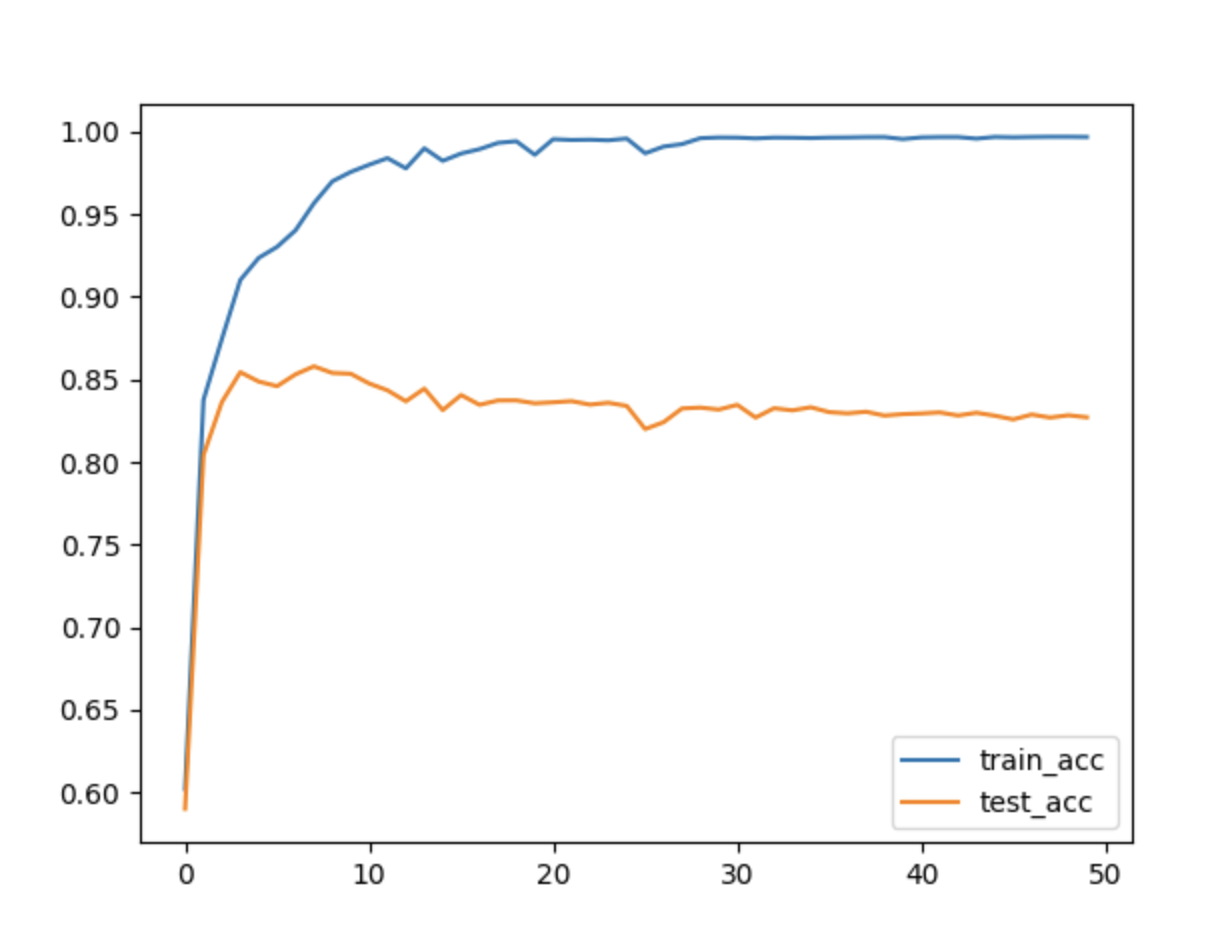

## [FEEDBACK] 기존 실습에서 사용한 hyper-parameter들과 위에서 구현한 Transformer를 가지고 5-layer 4-head Transformer의 성능 결과를 report해주시면 됩니다. 위 요구항이 있어서 위에서 파라미터를 수정하고 학습을 진행했는데요. 이 파라미터들 n_head의 크기 이런 값들도 이전처럼 제가 하나하나 찾아가면서 최적의 값을 찾아가야 하는지 궁금합니다.

## [FEEDBACK] 이번과제를 하면서 학습 시간이 굉장히 오래걸렸는데요. 현업에서 일하시면서 이 학습시간 때문에, 학습 파라미터를 훨씬 낮춘다던지 아니면 포기하던지 하는 의사결정을 수행하는지 궁금합니다. 파라미터와 학습시간 그 관계속에서 트레이드 오프를 어떻게 찾아가는지가 궁금합니다.